# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [4]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

Wall time: 1min 10s


In [5]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

### Manhattan Distance

In [38]:
# calculate manhattan distance

def manhattan_distance(a, b):
    return np.sum(np.absolute(np.matrix(a)-np.matrix(b)))

In [39]:
# Test, define data
row1 = [10, 20, 15, 10, 5]
row2 = [12, 24, 18, 8, 7]
# calculate distance
print(manhattan_distance(row1, row2))

13


### Erstelle Manhattan-Distanz für alle Filme

In [40]:
#again, implementation not efficient: better use lamda opperators (later in this course)
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=manhattan_distance(R[:,i],R[:,j])

In [41]:
np.save("movie_manhattan_dist",D)

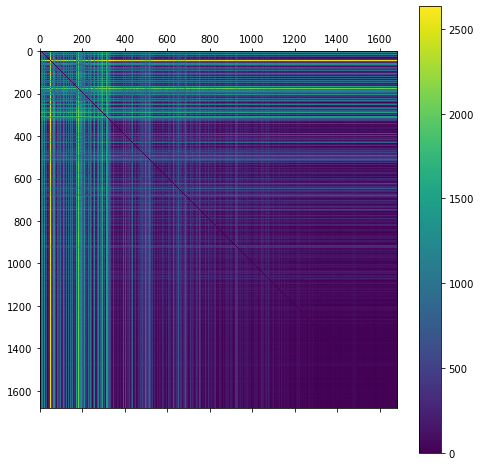

In [42]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar() 

### Anfragen an die Distanz

In [36]:
CII("Casab",D)

recommending movies for: 'Casablanca (1942)'


257          Contact (1997)
299    Air Force One (1997)
287           Scream (1996)
293        Liar Liar (1997)
312          Titanic (1997)
Name: title, dtype: object

In [37]:
#wie oft kommt ein Film (per ID) in der DB for
id=180
print(movies.title[id])
np.sum(ratings.movie_id==id)

Return of the Jedi (1983)


221

# Qualitätssicherung

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$
